## Predicting drive failure with XGBoost and RAPIDS

**Dataset**: Hard disk SMART data and failure dataset from Backblaze ([More information](https://www.backblaze.com/b2/hard-drive-test-data.html))

**Task**: Predict hard disk failure with RAPIDS

In [1]:
import time
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook

from sklearn.metrics import *

# RAPIDS
import cudf
import xgboost as xgb

### 1. Load Data

#### Training Data

Use Pandas to load training data from CSV. This consists of the pre-processed drive data from Feb 2017 to September 2018

In [2]:
df = pd.read_csv("train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9849 entries, 0 to 9848
Columns: 318 entries, failure to feat314
dtypes: float64(315), int64(3)
memory usage: 23.9 MB


Split into features (`df_train`) and labels(`df_target`), where each is a Pandas `Dataframe`.

In [3]:
df_train = df.drop(["failure"],axis=1).apply(pd.to_numeric).astype(np.float32)
df_train_target = pd.DataFrame(df["failure"]).apply(pd.to_numeric)

#### Evaluation Data

Do the same thing to load evaluation data from CSV, if you have a seperate file to load. In our case, this consists of the pre-processed drive data from October 2017 to December 2018

In [4]:
df_t = pd.read_csv("eval.csv")
df_t.info()

df_test = df_t.drop(["failure"],axis=1).apply(pd.to_numeric).astype(np.float32)
df_test_target = pd.DataFrame(df_t["failure"]).apply(pd.to_numeric)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4464 entries, 0 to 4463
Columns: 318 entries, failure to feat314
dtypes: float64(315), int64(3)
memory usage: 10.8 MB


### 2. Train with CPU

XGBoost training with CPU (`params[tree_method] = 'hist'`), using a Pandas `Dataframe` loaded into `xgb.DMatrix`. For more information, check out [this page in the XGBoost Documentation](https://xgboost.readthedocs.io/en/latest/python/python_intro.html).

In [5]:
MAX_TREE_DEPTH = 6
TREE_METHOD = 'hist'
ITERATIONS = 150
SUBSAMPLE = 0.6
REGULARIZATION = 1.3
GAMMA = 0.3
POS_WEIGHT = 3
EARLY_STOP = 6

In [6]:
!lscpu | grep 'Model name:'
!lscpu | grep 'CPU(s)'

Model name:          Intel(R) Xeon(R) CPU E5-2698 v4 @ 2.20GHz
CPU(s):              40
On-line CPU(s) list: 0-39
NUMA node0 CPU(s):   0-39


In [7]:
start_time = time.time()

xgtrain = xgb.DMatrix(df_train, df_train_target)
xgeval = xgb.DMatrix(df_test, df_test_target)

params = {'tree_method': TREE_METHOD, 'max_depth': MAX_TREE_DEPTH, 'alpha': REGULARIZATION,
          'gamma': GAMMA, 'subsample': SUBSAMPLE, 'scale_pos_weight': POS_WEIGHT, 'learning_rate': 0.05, 'silent': 1}

bst = xgb.train(params, xgtrain, ITERATIONS, evals=[(xgtrain, "train"), (xgeval, "eval")],
                early_stopping_rounds=EARLY_STOP)

timetaken_cpu = time.time() - start_time

# free up memory
del xgtrain
del bst

[19:49:09] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[0]	train-rmse:0.489444	eval-rmse:0.489139
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 6 rounds.
[1]	train-rmse:0.479429	eval-rmse:0.478774
[2]	train-rmse:0.470476	eval-rmse:0.469613
[3]	train-rmse:0.462065	eval-rmse:0.460645
[4]	train-rmse:0.454239	eval-rmse:0.452911
[5]	train-rmse:0.446974	eval-rmse:0.446759
[6]	train-rmse:0.440404	eval-rmse:0.44117
[7]	train-rmse:0.434136	eval-rmse:0.436512
[8]	train-rmse:0.428172	eval-rmse:0.432187
[9]	train-rmse:0.422746	eval-rmse:0.427698
[10]	train-rmse:0.417667	eval-rmse:0.423876
[11]	train-rmse:0.412952	eval-rmse:0.419046
[12]	train-rmse:0.408174	eval-rmse:0.415682
[13]	train-rmse:0.40406	eval-rmse:0.41152
[14]	train-rmse:0.400145	eval-rmse:0.407015
[15]	train-rmse:0.39634	eval-rmse:0.403195
[16]	train-rmse:0.393252	eval-rmse:0.401722
[17]	train-rmse:0.390082	e

### 3. Train with GPU

To use GPU, we set `params[tree_method] = 'gpu_hist'` and also (optionally) load the Pandas `Dataframe` into cuDF Dataframe (Python object type `cudf.dataframe.dataframe.DataFrame`).

In [8]:
# run 1
# GPU, without using cuDF

start_time = time.time()

xgtrain = xgb.DMatrix(df_train, df_train_target)
xgeval = xgb.DMatrix(df_test, df_test_target)

params = {'tree_method': "gpu_"+TREE_METHOD, 'max_depth': MAX_TREE_DEPTH, 'alpha': REGULARIZATION,
          'gamma': GAMMA, 'subsample': SUBSAMPLE, 'scale_pos_weight': POS_WEIGHT, 'learning_rate': 0.05, 'silent': 1}

bst = xgb.train(params, xgtrain, ITERATIONS, evals=[(xgtrain, "train"), (xgeval, "eval")],
                early_stopping_rounds=EARLY_STOP)

timetaken_gpu_nocudf = time.time() - start_time

# free up memory
del xgtrain
del bst

[0]	train-rmse:0.489638	eval-rmse:0.489468
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 6 rounds.
[1]	train-rmse:0.479783	eval-rmse:0.4789
[2]	train-rmse:0.470634	eval-rmse:0.470793
[3]	train-rmse:0.46184	eval-rmse:0.461773
[4]	train-rmse:0.454247	eval-rmse:0.454197
[5]	train-rmse:0.446661	eval-rmse:0.445346
[6]	train-rmse:0.439749	eval-rmse:0.43808
[7]	train-rmse:0.433233	eval-rmse:0.431424
[8]	train-rmse:0.427393	eval-rmse:0.426518
[9]	train-rmse:0.421875	eval-rmse:0.420127
[10]	train-rmse:0.416776	eval-rmse:0.416659
[11]	train-rmse:0.41207	eval-rmse:0.412244
[12]	train-rmse:0.407678	eval-rmse:0.407402
[13]	train-rmse:0.403543	eval-rmse:0.403966
[14]	train-rmse:0.399591	eval-rmse:0.3995
[15]	train-rmse:0.396128	eval-rmse:0.396851
[16]	train-rmse:0.392609	eval-rmse:0.394357
[17]	train-rmse:0.389641	eval-rmse:0.390768
[18]	train-rmse:0.386544	eval-rmse:0.388934
[19]	train-rmse:0.383469	eval-rmse:0.38

In [9]:
# load into cuDF Dataframe

gdf_train = cudf.DataFrame.from_pandas(df_train)
gdf_train_target = cudf.DataFrame.from_pandas(df_train_target)

gdf_eval = cudf.DataFrame.from_pandas(df_test)
gdf_eval_target = cudf.DataFrame.from_pandas(df_test_target)

In [10]:
# run 2
# GPU, with using cuDF

start_time = time.time()

xgtrain = xgb.DMatrix(gdf_train, gdf_train_target)
xgeval = xgb.DMatrix(gdf_eval, gdf_eval_target)

params = {'tree_method': "gpu_"+TREE_METHOD, 'max_depth': MAX_TREE_DEPTH, 'alpha': REGULARIZATION,
          'gamma': GAMMA, 'subsample': SUBSAMPLE, 'scale_pos_weight': POS_WEIGHT, 'learning_rate': 0.05, 'silent': 1}

bst = xgb.train(params, xgtrain, ITERATIONS, evals=[(xgtrain, "train"), (xgeval, "eval")],
                early_stopping_rounds=EARLY_STOP)

timetaken_gpu = time.time() - start_time

[0]	train-rmse:0.489638	eval-rmse:0.489468
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 6 rounds.
[1]	train-rmse:0.479783	eval-rmse:0.4789
[2]	train-rmse:0.470634	eval-rmse:0.470793
[3]	train-rmse:0.46184	eval-rmse:0.461773
[4]	train-rmse:0.454247	eval-rmse:0.454197
[5]	train-rmse:0.446661	eval-rmse:0.445346
[6]	train-rmse:0.439749	eval-rmse:0.43808
[7]	train-rmse:0.433233	eval-rmse:0.431424
[8]	train-rmse:0.427393	eval-rmse:0.426518
[9]	train-rmse:0.421875	eval-rmse:0.420127
[10]	train-rmse:0.416776	eval-rmse:0.416659
[11]	train-rmse:0.41207	eval-rmse:0.412244
[12]	train-rmse:0.407678	eval-rmse:0.407402
[13]	train-rmse:0.403543	eval-rmse:0.403966
[14]	train-rmse:0.399591	eval-rmse:0.3995
[15]	train-rmse:0.396128	eval-rmse:0.396851
[16]	train-rmse:0.392609	eval-rmse:0.394357
[17]	train-rmse:0.389641	eval-rmse:0.390768
[18]	train-rmse:0.386544	eval-rmse:0.388934
[19]	train-rmse:0.383469	eval-rmse:0.38

In [11]:
print("Check GPU memory usage")
!gpustat

Check GPU memory usage
jupyter-timothy-5fliu  Wed Jan 23 19:49:20 2019
[0] Tesla V100-DGXS-16GB | 43'C,   0 % |   711 / 16125 MB |


### 4. Results

We see a significant speed-up when we use the RAPIDS stack.

In [12]:
print("CPU Time Taken:\n", round(timetaken_cpu,1))
print("\nGPU (no cuDF) Time Taken:\n", round(timetaken_gpu_nocudf,1))
print("\nGPU (cuDF) Time Taken:\n", round(timetaken_gpu,1))
print("\nTotal speed-up with RAPIDS:\n", round(timetaken_cpu/timetaken_gpu*100,1), "%")

CPU Time Taken:
 6.0

GPU (no cuDF) Time Taken:
 1.1

GPU (cuDF) Time Taken:
 0.8

Total speed-up with RAPIDS:
 797.0 %


#### Let's look at the model's performance

In [13]:
preds = bst.predict(xgeval)

y_pred = []

THRESHOLD = 0.5

for pred in preds:
    if pred<=THRESHOLD:
        y_pred.append(0)
    if pred>THRESHOLD:
        y_pred.append(1)

y_pred = np.asarray(y_pred)
        
y_true = df_test_target.values.reshape(len(preds))

In [14]:
print("Accuracy (Eval)", round(accuracy_score(y_true, y_pred),3))

Accuracy (Eval) 0.885


In [15]:
print(classification_report(y_true, y_pred, target_names=["normal", "fail"]))

              precision    recall  f1-score   support

      normal       0.97      0.90      0.94      4150
        fail       0.34      0.66      0.44       314

   micro avg       0.88      0.88      0.88      4464
   macro avg       0.65      0.78      0.69      4464
weighted avg       0.93      0.88      0.90      4464



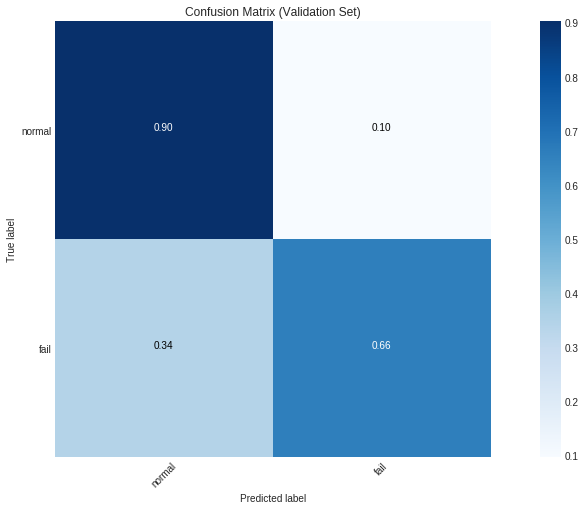

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn-dark')
def plot_confusion_matrix(cm, labels,
                          normalize=True,
                          title='Confusion Matrix (Validation Set)',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(14,7))
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, labels=["normal", "fail"])